#### Learning of Structured Data - Portfolio  3
---
*Group 1* - Main LSTM approach

Contributors: Max Werner, Kilian Hümmer, Fikrat Mutallimov and Phuoc Nguyen Pham

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import os
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn

**Exercise1: 'Data set'**

Create a data set import script
* Load the time series movement sequence data set in the *.csv* format. The sequences
are time recordings of movements (joint angles) with different lengths. Labels are
given in the file names.

* Try to visualize the data to get a first idea

In [ ]:
df_train = pd.read_csv("data/train/train/10143855_rowing.csv", header=None, usecols=range(0, 75))
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,267.730682,117.018677,0.895402,279.800842,185.387146,0.895754,209.508896,199.382751,0.793637,183.428574,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,267.000000,118.000000,1.000000,279.000000,186.000000,1.000000,209.000000,201.000000,1.000000,183.000000,...,0.0,-0.363440,-0.021049,0.0,-0.363440,-0.021049,0.0,-0.363440,-0.021049,0.0
2,266.000000,119.000000,1.000000,278.000000,187.000000,1.000000,209.000000,202.000000,1.000000,184.000000,...,0.0,-0.182489,0.001790,0.0,-0.182489,0.001790,0.0,-0.182489,0.001790,0.0
3,265.000000,120.000000,1.000000,277.000000,188.000000,1.000000,209.000000,203.000000,1.000000,184.000000,...,0.0,-0.118099,0.006548,0.0,-0.118099,0.006548,0.0,-0.118099,0.006548,0.0
4,265.000000,121.000000,1.000000,277.000000,189.000000,1.000000,210.000000,202.000000,1.000000,184.000000,...,0.0,-0.110839,0.012986,0.0,-0.110839,0.012986,0.0,-0.110839,0.012986,0.0


In [ ]:
# connections between joints for visualization
connections = [
    (0, 1), (0, 15), (0, 16),
    (1, 2), (1, 8), (1, 5),
    (2, 3),
    (3, 4),
    (5, 6),
    (6, 7),
    (8, 9), (8, 12),
    (9, 10),
    (10, 11),
    (11, 24), (11, 22),
    (22, 23),
    (14, 19), (14, 21),
    (19, 20),
    (12, 13),
    (13, 14),
    (15, 17),
    (16, 18)
]

In [ ]:
def plot_single_pose(pose):
    plt.scatter(pose[:, 0], pose[:, 1], alpha=pose[:, 2])
    for connection in connections:
        confidence_values = pose[connection, 2]
        if not np.any(confidence_values < 0.1):
            x = pose[connection, 0]
            y = pose[connection, 1]
            plt.plot(x, y, color='black')
    plt.gca().set_xlim(0, 640)
    plt.gca().set_ylim(480, 0)
    plt.show()

In [ ]:
def plot_motion_all(motion_df):
    for _, row in motion_df.iterrows():
        pose = row.to_numpy().reshape(-1, 3)
        plt.scatter(pose[:, 0], pose[:, 1], alpha=pose[:, 2])
    plt.gca().set_xlim(0, 640)
    plt.gca().set_ylim(480, 0)
    plt.show()

In [ ]:
def plot_motion_animated(motion_df, frame_count = 100):
    fig, ax = plt.subplots()
    scatter = None
    lines = []

    def update(frame):
        nonlocal scatter, lines

        if not motion_df.empty and frame < len(motion_df):
            pose = motion_df.iloc[frame].to_numpy().reshape(-1, 3)

            if scatter is None:
                scatter = ax.scatter(pose[:, 0], pose[:, 1], alpha=pose[:, 2])
            else:
                scatter.set_offsets(pose[:, :2])

            for line in lines:
                line.remove()
            lines = []

            for connection in connections:
                confidence_values = pose[connection, 2]
                if not np.any(confidence_values < 0.1):
                    x = pose[connection, 0]
                    y = pose[connection, 1]
                    if connection == (3, 4) or connection == (6, 7):
                        line, = ax.plot(x, y, color='red')
                    else:
                        line, = ax.plot(x, y, color='black')
                    lines.append(line)

            return scatter, *lines

    ax.set_xlim(0, 640)
    ax.set_ylim(480, 0)

    if frame_count > len(motion_df):
        frame_count = len(motion_df)

    animation = FuncAnimation(fig, update, frames=frame_count, interval=33.34)
    plt.close(fig)
    return HTML(animation.to_jshtml())

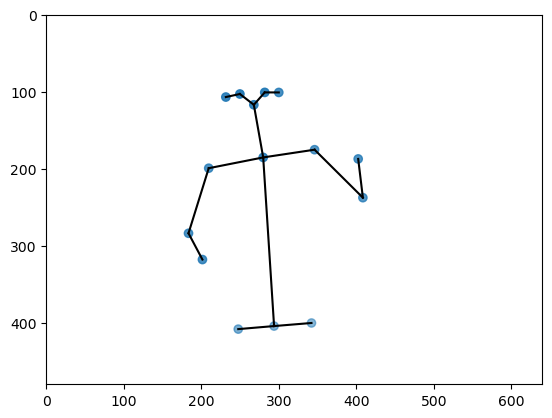

In [ ]:
plot_single_pose(df_train.iloc[0].to_numpy().reshape(-1, 3))

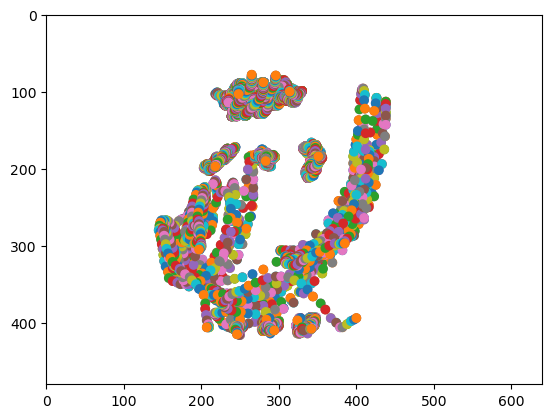

In [ ]:
plot_motion_all(df_train)

In [ ]:
plot_motion_animated(df_train)

In [ ]:
def load_dataset_csv(directory_path, reduce_to_arms = False, sort_numerically = False):
    X_data = []

    filenames = os.listdir(directory_path)
    if sort_numerically:
        filenames = sorted(os.listdir(directory_path), key=lambda x: int(x.split('.')[0]))

    for filename in filenames:
        if filename.endswith(".csv"):
            if reduce_to_arms == False:
                df = pd.read_csv(os.path.join(directory_path, filename), header=None, usecols=range(0, 75))
            else:
                df = pd.read_csv(os.path.join(directory_path, filename), header=None, usecols=[9, 10, 12, 13, 18, 19, 21, 22])
            X_data.append(df.to_numpy())

    return X_data

def load_labels(directory_path):
    y_data = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            y_value = filename.split('_')[1].split('.')[0]
            y_data.append(y_value)
    return y_data

In [ ]:
def convert_X_to_tensor(X, frames):
    extended_X = []
    for sample in X:
        sample = torch.tensor(sample, dtype=torch.float32)
        if sample.shape[0] < frames:
            repeated_sample = sample
            while repeated_sample.shape[0] < frames:
                repeated_sample = torch.cat([repeated_sample, sample], dim=0)
            extended_X.append(repeated_sample[:frames, :])
        else:
            extended_X.append(sample[:frames, :])
    return torch.stack(extended_X)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, frames=200):
        self.frames = frames
        self.X = convert_X_to_tensor(X, frames)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.y is not None:
            y = self.y[idx].item()
            return x, y
        else:
            return x

In [ ]:
X = load_dataset_csv("data/train/train", reduce_to_arms=True)
y = load_labels("data/train/train")

In [ ]:
label_counts = Counter(y)
df = pd.DataFrame(list(label_counts.items()), columns=['label', 'occurrences'], index=None)
df

,label,occurrences
0,rowing,235
1,guitar,230
2,boxing,243
3,violin,229
4,drums,230


**Exercise2: ‘Embedding and Modeling’**

In the lecture we have discussed some techniques to handle temporal data / time series data.

Select a technique how to represent / process the given data - this could be an
explicit or implicit data representation or also a simple statistic like histograms,
bit-encodings or alike

* Process the data to obtain a meaning and powerful representation

* Create a process to obtain a classification or clustering model for the given data.
This should include meta parameter optimization.

* Provide a brief explanation of the algorithm-design you used.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def evaluate_accuracy(model, data_loader):
    model.eval()
    count = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs.to(device))
            predictions = torch.argmax(outputs, dim=1)
            count += (predictions==labels.to(device)).sum()
    return count.item()/len(data_loader.dataset)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(["boxing", "drums", "guitar", "rowing", "violin"])
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
class_labels = label_encoder.classes_

In [ ]:
print("Device set to:", device)

eval_train_test_accuracies = True

frames = 400

num_epochs = 100
batch_size = 10
input_size = 8
hidden_size = 256
num_layers = 4
num_classes = len(class_labels)
learning_rate = 0.00005

train_dataset = TimeSeriesDataset(X_train, y_train_encoded, frames)
test_dataset = TimeSeriesDataset(X_test, y_test_encoded, frames)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
test_accuracies = []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(labels)

    if eval_train_test_accuracies:
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc = evaluate_accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    average_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(average_loss)

Device set to: cuda


**Exercise3: ‘Evaluation’**
* Estimate theoretical and practical the memory and runtime complexity of your
approach - make a distinction between training and test. Address also the sparsity
of your model.

* Evaluate the resulting model by appropriate evaluation measures (cross validation,AUC,NMI or alike)

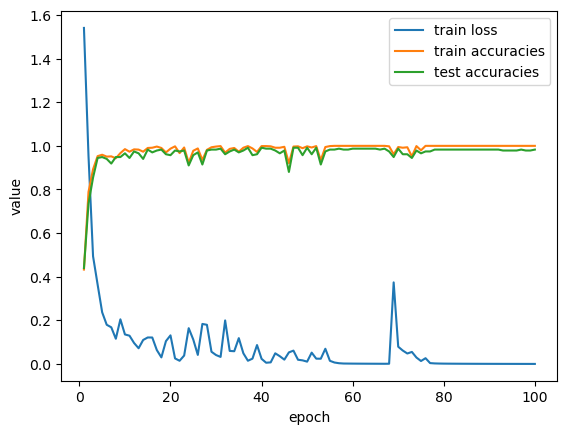

In [ ]:

plt.plot(range(1, num_epochs + 1), train_losses, label = "train loss")
if eval_train_test_accuracies:
    plt.plot(range(1, num_epochs + 1), train_accuracies, label = "train accuracies")
    plt.plot(range(1, num_epochs + 1), test_accuracies, label = "test accuracies")

plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.show()

In [ ]:
model.eval()

all_predictions = []
all_labels = []
model.to("cpu")
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.append(predictions.numpy())
        all_labels.append(labels.numpy())

all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

all_labels_txt = label_encoder.inverse_transform(all_labels)
all_predictions_txt = label_encoder.inverse_transform(all_predictions)

print(classification_report(all_labels_txt, all_predictions_txt))

              precision    recall  f1-score   support

      boxing       0.98      1.00      0.99        52
       drums       0.96      1.00      0.98        47
      guitar       0.98      0.95      0.96        43
      rowing       1.00      0.98      0.99        55
      violin       1.00      0.97      0.99        37

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234



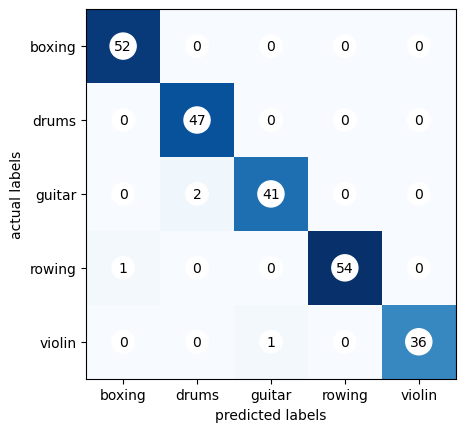

In [ ]:
conf_matrix = confusion_matrix(all_labels_txt, all_predictions_txt)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)

tick_marks = np.arange(len(class_labels))
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black", bbox=dict(facecolor="white", edgecolor="white", boxstyle="circle"))

plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)
plt.xlabel("predicted labels")
plt.ylabel("actual labels")
plt.show()

Runtime and memory evaluation for some parameter variations.

|metrics|reference (as above)| `hidden_size` $/ 2 $ | `num_layers`  $/ 2 $ | `frames` $/ 2 $ |
|-|-|-|-|-|
|training time| 495 s | 75 s | 256 s | 257 s |
|training time rel| 1.00 | 0.15 | 0.52 | 0.52 |
|model size| 7.07 MB | 1.79 MB | 3.05 MB | 7.06 MB |
|model size rel| 1.00 | 0.25 | 0.43 | 0.99 |

* `hidden_size`: Significant impact on both time and memory complexity
* `num_layers`: About linear impact on both time and memory complexity
* `frames` (or input length): Linear impact on time complexity; no impact on memory complexity

Predict Kaggle test data with the trained model.

In [ ]:
X_test_kaggle = load_dataset_csv("data/test/test", reduce_to_arms=True, sort_numerically=True)

test_batch_kaggle = convert_X_to_tensor(X_test_kaggle, frames)

with torch.no_grad():
    model.eval()
    preds_kaggle = model(test_batch_kaggle)

all_predictions_kaggle = torch.argmax(preds_kaggle, dim=1)

all_predictions_kaggle_txt = label_encoder.inverse_transform(all_predictions_kaggle)

df_predictions_kaggle = pd.DataFrame(all_predictions_kaggle, columns=['action'])
df_predictions_kaggle = df_predictions_kaggle.rename_axis('id')
df_predictions_kaggle.head()

,action
id,
0,2
1,1
2,2
3,1
4,2


In [ ]:
df_predictions_kaggle.to_csv('output_kaggle.csv')